In [16]:
import os
import random
import shutil
!pip install labelme tensorflow opencv-python matplotlib albumentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [9]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os

In [ ]:
!mkdir -p data/{train,test,val}/{images,labels}

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [11]:
import os
images = tf.data.Dataset.list_files(os.path.join('data', 'images', '*.jpg'), shuffle=False)

In [12]:
images.as_numpy_iterator().next()

b'data/images/0132fc4e-896c-11ee-aed7-df8acdbd3581.jpg'

In [11]:
def load_image(path): 
    byte_img = tf.io.read_file(path)
    loaded_image = tf.io.decode_jpeg(byte_img)
    return loaded_image

In [14]:
images = images.map(load_image)

In [15]:
images.as_numpy_iterator().next()

array([[[105,  98,  92],
        [107, 100,  94],
        [105,  97,  94],
        ...,
        [113, 102, 100],
        [111, 100,  98],
        [112, 101,  99]],

       [[105,  98,  92],
        [108, 101,  95],
        [106,  98,  95],
        ...,
        [113, 102, 100],
        [110,  99,  97],
        [108,  97,  95]],

       [[106,  97,  90],
        [110, 101,  94],
        [111, 102,  97],
        ...,
        [113, 102, 100],
        [110,  99,  97],
        [109,  98,  96]],

       ...,

       [[134, 124,  99],
        [137, 127, 102],
        [140, 129, 107],
        ...,
        [ 66,  62,  50],
        [ 62,  58,  47],
        [ 60,  56,  44]],

       [[137, 125, 101],
        [138, 126, 102],
        [138, 126, 104],
        ...,
        [ 65,  59,  45],
        [ 62,  56,  44],
        [ 63,  57,  43]],

       [[135, 123,  99],
        [137, 125, 101],
        [139, 127, 105],
        ...,
        [ 66,  60,  46],
        [ 65,  57,  44],
        [ 63,  55,  42]]

In [16]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [23]:
plot_images = image_generator.next()

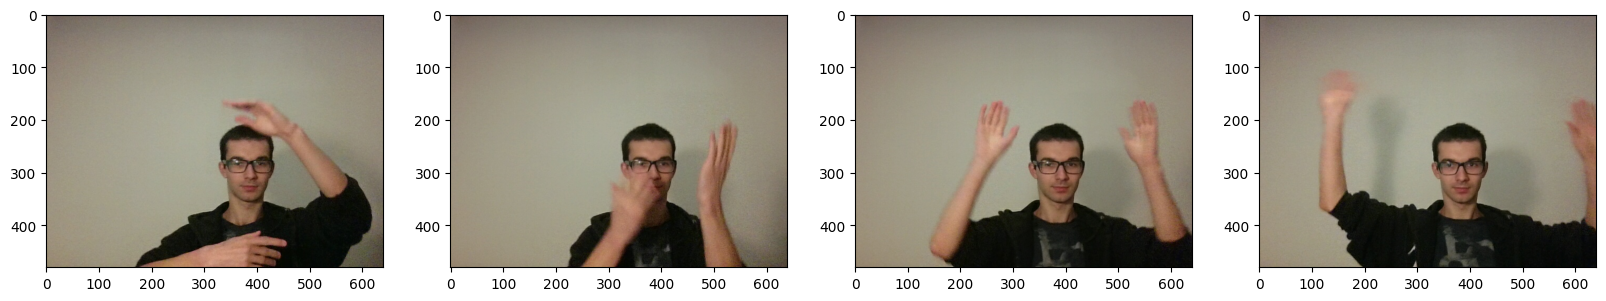

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Split Images # https://www.google.com/search?q=linux+move+n+random+files

In [12]:
## split images 
## linux move n random files -> https://stackoverflow.com/questions/14033129/how-to-move-a-given-number-of-random-files-on-unix-linux-os
# !shuf -n 63 -e data/images/* | xargs -i mv {} data/train/images
# !shuf -n 14 -e data/images/* | xargs -i mv {} data/test/images
# !shuf -n 13 -e data/images/* | xargs -i mv {} data/val/images

In [10]:
import os
import shutil
import random


def shuffle_and_move(count: int, data_dir: str):
    source_directory = os.path.join('data', 'images')
    destination_directory = os.path.join('data', data_dir, 'images')
    files = os.listdir(source_directory)
    random.shuffle(files)
    files = files[:count]
    for file in files:
        old_path = os.path.join(source_directory, file)
        new_path = os.path.join(destination_directory, file)
        shutil.move(old_path, new_path)
            

In [11]:
shuffle_and_move(63, 'train')
shuffle_and_move(14, 'test')
shuffle_and_move(13, 'val')

In [13]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [4]:
import cv2
import albumentations as alb

augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

In [23]:
img_name = os.listdir(os.path.join('data', 'train', 'images'))[0]
print(img_name)
img = cv2.imread(os.path.join('data', 'train', 'images', img_name))


0132fc4e-896c-11ee-aed7-df8acdbd3581.jpg


In [26]:
with open(os.path.join('data', 'train', 'labels', img_name.replace('.jpg', '.json')), 'r') as f:
    label = json.load(f)

In [28]:
label['shapes'][0]['points']

[[263.8423645320197, 103.79310344827587],
 [376.6502463054187, 262.90640394088666]]

In [29]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [30]:
coords

[263.8423645320197, 103.79310344827587, 376.6502463054187, 262.90640394088666]

In [31]:
coords = list(np.divide(coords, [640,480,640,480]))

In [32]:
coords

[0.4122536945812808,
 0.21623563218390807,
 0.5885160098522167,
 0.5477216748768472]

In [36]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['hand'])

In [40]:
augmented['bboxes'][0][2:]

(0.5547783251231527, 0.7871264367816092)

In [41]:
augmented['bboxes']

[(0.3040941434044882,
  0.4335413245758074,
  0.5547783251231527,
  0.7871264367816092)]

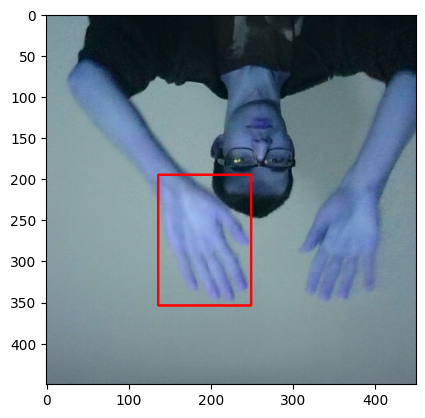

In [42]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

In [43]:
!mkdir -p aug_data/{train,test,val}/{images,labels}

In [45]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['hand'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),
                            augmented['image'])

                annotation = {'image': image}

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [5]:
def load_images_into_dataset(dir_name: str):
    loaded_images = tf.data.Dataset.list_files(os.path.join('aug_data', dir_name, 'images', '*.jpg'), shuffle=False)
    loaded_images = loaded_images.map(load_image)
    loaded_images = loaded_images.map(lambda y: tf.image.resize(y, (120, 120)))
    loaded_images = loaded_images.map(lambda y: y / 255)
    return loaded_images

In [12]:
train_images = load_images_into_dataset('train')
test_images = load_images_into_dataset('test')
val_images = load_images_into_dataset('val')

In [16]:
train_images.as_numpy_iterator().next()

array([[[0.        , 0.07653186, 0.02555147],
        [0.        , 0.08051471, 0.02922794],
        [0.        , 0.08872549, 0.03529412],
        ...,
        [0.48480392, 0.547549  , 0.43382353],
        [0.49656862, 0.56078434, 0.44656864],
        [0.49319854, 0.55441177, 0.43762255]],

       [[0.        , 0.0754902 , 0.02530637],
        [0.        , 0.08186275, 0.03480392],
        [0.        , 0.08578432, 0.03872549],
        ...,
        [0.49460784, 0.55735296, 0.44362745],
        [0.5043505 , 0.5685662 , 0.45520833],
        [0.49325982, 0.5560049 , 0.4452206 ]],

       [[0.        , 0.0759804 , 0.03137255],
        [0.        , 0.08192402, 0.0348652 ],
        [0.        , 0.07892157, 0.03186275],
        ...,
        [0.50085783, 0.5740809 , 0.45686275],
        [0.50735295, 0.5715686 , 0.45735294],
        [0.49577206, 0.55851716, 0.44479167]],

       ...,

       [[0.44773284, 0.5457721 , 0.47126225],
        [0.44264707, 0.54068625, 0.46617648],
        [0.4452206 , 0

# Prepare Labels

In [13]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [14]:
def load_labels_into_dataset(dir_name: str):
    loaded_labels = tf.data.Dataset.list_files(os.path.join('aug_data', dir_name, 'labels', '*.json'), shuffle=False)
    loaded_labels = loaded_labels.map(lambda y: tf.py_function(load_labels, [y], [tf.int32, tf.float32]))
    return loaded_labels

train_labels = load_labels_into_dataset('train')
test_labels = load_labels_into_dataset('test')
val_labels = load_labels_into_dataset('val')

In [15]:
train_labels.as_numpy_iterator().next()


(array([1], dtype=int32),
 array([0.218555  , 0.4624302 , 0.46923918, 0.8160153 ], dtype=float32))

# Combine Images and Labels

In [17]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [18]:
def zip_dataset(images_, labels):
    return tf.data.Dataset.zip((images_, labels)).shuffle(len(labels) + 1).batch(8).prefetch(4)

train = zip_dataset(train_images, train_labels)
test = zip_dataset(test_images, test_labels)
val = zip_dataset(val_images, val_labels)

In [19]:
len(train), len(test), len(val)

(473, 105, 98)

In [20]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=int32),
 array([[0.537526  , 0.5190914 , 0.86483854, 0.8847181 ],
        [0.35662836, 0.3329283 , 0.60512316, 0.71935415],
        [0.38043788, 0.        , 0.70337164, 0.45238096],
        [0.470104  , 0.66086483, 0.78428024, 0.9794198 ],
        [0.3774275 , 0.17954023, 0.62811166, 0.53312534],
        [0.25315818, 0.18029557, 0.7118336 , 0.91702247],
        [0.16004379, 0.27816093, 0.38007662, 0.6930487 ],
        [0.00765189, 0.        , 0.7892611 , 0.89543515]], dtype=float32))

In [21]:
data_samples = train.as_numpy_iterator()

In [22]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


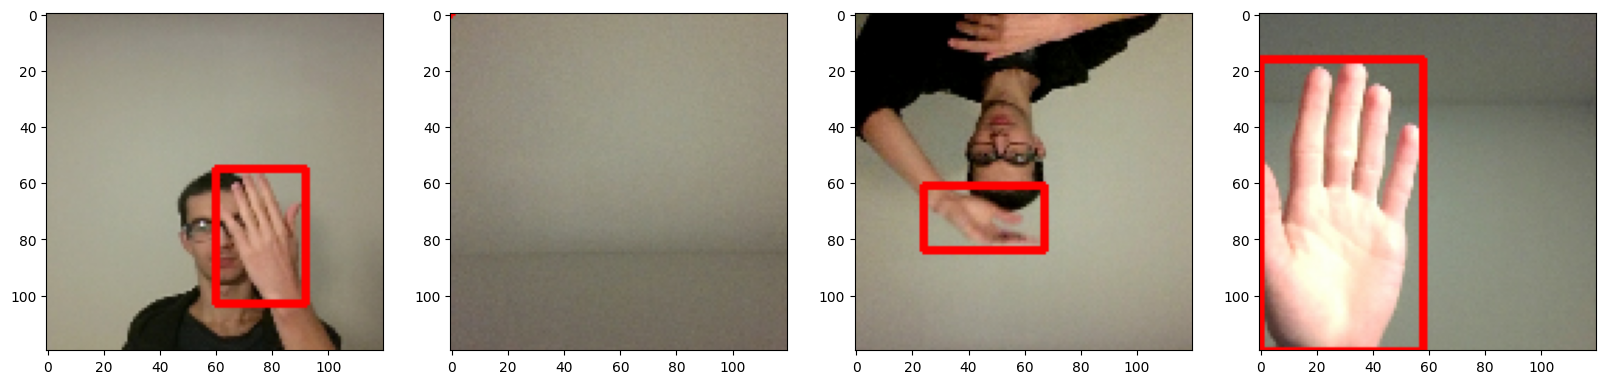

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image)

# Create the Deep Learning Model

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16


In [26]:
vgg = VGG16(include_top=False)

In [27]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [32]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    tracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return tracker

In [33]:
tracker = build_model()

In [34]:
tracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [35]:
X, y = train.as_numpy_iterator().next()

In [38]:
X.shape

(8, 120, 120, 3)

In [39]:
classes, coords = tracker.predict(X)

1/1 [==============================] - 1s 948ms/step


In [40]:
classes, coords

(array([[0.40237927],
        [0.43597773],
        [0.41802344],
        [0.4176907 ],
        [0.43425265],
        [0.37644422],
        [0.5044128 ],
        [0.4423795 ]], dtype=float32),
 array([[0.3837596 , 0.6449276 , 0.5713841 , 0.47030008],
        [0.39324123, 0.7097781 , 0.5097403 , 0.46700767],
        [0.36694193, 0.7281358 , 0.5290595 , 0.4894429 ],
        [0.41647905, 0.6406274 , 0.5796312 , 0.4345956 ],
        [0.3377168 , 0.7013359 , 0.5361936 , 0.5171377 ],
        [0.31350416, 0.6831378 , 0.6330434 , 0.50068665],
        [0.36232352, 0.63292706, 0.56245   , 0.47504988],
        [0.4153853 , 0.6417144 , 0.59607816, 0.49152023]], dtype=float32))

# Define Loss Functions

In [41]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [43]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [44]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [45]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [46]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.5160494>

In [47]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.849602>

In [48]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.5160494>

In [50]:
class Tracker(Model):
    def __init__(self, tracker, **kwargs):
        super().__init__(**kwargs)
        self.model = tracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [51]:
model = Tracker(tracker)

In [52]:
model.compile(opt, classloss, regressloss)

In [53]:
logdir='logs'

In [54]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# TODO: 10 or 40 epochs?
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
293/473 [=================>............] - ETA: 2:17 - total_loss: 0.7814 - class_loss: 0.1684 - regress_loss: 0.6972

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Predictions

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = tracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0), 2)

    ax[idx].imshow(sample_image)

In [55]:
from tensorflow.keras.models import load_model

In [ ]:
tracker.save('tracker.h5')

In [ ]:
tracker = load_model('tracker.h5')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = tracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'hand', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('HandTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()